In [72]:
"""
clean_airbench.py
"""

#############################################
#            Setup/Hyperparameters          #
#############################################

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from airbench import evaluate, CifarLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True

hyp = {
    'opt': {
        'epochs': 15,
        'batch_size': 1000,
        'lr': 5.0,             # learning rate per 1024 examples -- 5.0 is optimal with no smoothing, 10.0 with smoothing.
        'momentum': 0.85,
        'weight_decay': 0.015,  # weight decay per 1024 examples (decoupled from learning rate)
        'bias_scaler': 64.0,    # scales up learning rate (but not weight decay) for BatchNorm biases
#         'label_smoothing': 0.2,
        'label_smoothing': 0.0,
    },
    'aug': {
        'flip': True,
        'translate': 2,
    },
    'net': {
        'widths': {
            'block1': 64,
            'block2': 256,
            'block3': 256,
        },
        'scaling_factor': 1/9,
        'tta_level': 2,
    },
}

#############################################
#            Network Components             #
#############################################

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Mul(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
    def forward(self, x):
        return x * self.scale

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-12,
                 weight=False, bias=True):
        super().__init__(num_features, eps=eps)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias
        # Note that PyTorch already initializes the weights to one and bias to zero

class Conv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding='same', bias=False):
        super().__init__(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)

    def reset_parameters(self):
        super().reset_parameters()
        if self.bias is not None:
            self.bias.data.zero_()
        w = self.weight.data
        torch.nn.init.dirac_(w[:w.size(1)])

class ConvGroup(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = Conv(channels_in,  channels_out)
        self.pool = nn.MaxPool2d(2)
        self.norm1 = BatchNorm(channels_out)
        self.conv2 = Conv(channels_out, channels_out)
        self.norm2 = BatchNorm(channels_out)
        self.activ = nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.norm1(x)
        x = self.activ(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activ(x)
        return x

#############################################
#            Network Definition             #
#############################################

## The eigenvectors of the covariance matrix of 2x2 patches of CIFAR-10 divided by sqrt eigenvalues.
eigenvectors_scaled = torch.tensor([
 8.9172e-02,  8.9172e-02,  8.8684e-02,  8.8623e-02,  9.3872e-02,  9.3872e-02,  9.3018e-02,  9.3018e-02,
 9.0027e-02,  9.0027e-02,  8.9233e-02,  8.9172e-02,  3.8818e-01,  3.8794e-01,  3.9111e-01,  3.9038e-01,
-1.0767e-03, -1.3609e-03,  3.8567e-03,  3.2330e-03, -3.9087e-01, -3.9087e-01, -3.8428e-01, -3.8452e-01,
-4.8242e-01, -4.7485e-01,  4.5435e-01,  4.6216e-01, -4.6240e-01, -4.5557e-01,  4.8975e-01,  4.9658e-01,
-4.3311e-01, -4.2725e-01,  4.2285e-01,  4.2896e-01, -5.0781e-01,  5.1514e-01, -5.1562e-01,  5.0879e-01,
-5.1807e-01,  5.2783e-01, -5.2539e-01,  5.1904e-01, -4.6460e-01,  4.7070e-01, -4.7168e-01,  4.6240e-01,
-4.7290e-01, -4.7461e-01, -5.0635e-01, -5.0684e-01,  9.5410e-01,  9.5117e-01,  9.2090e-01,  9.1846e-01,
-4.7363e-01, -4.7607e-01, -5.0439e-01, -5.0586e-01, -1.2539e+00,  1.2490e+00,  1.2383e+00, -1.2354e+00,
-1.2637e+00,  1.2666e+00,  1.2715e+00, -1.2725e+00, -1.1396e+00,  1.1416e+00,  1.1494e+00, -1.1514e+00,
-2.8262e+00, -2.7578e+00,  2.7617e+00,  2.8438e+00,  3.9404e-01,  3.7622e-01, -3.8330e-01, -3.9502e-01,
 2.6602e+00,  2.5801e+00, -2.6055e+00, -2.6738e+00, -2.9473e+00,  3.0312e+00, -3.0488e+00,  2.9648e+00,
 3.9111e-01, -4.0063e-01,  3.7939e-01, -3.7451e-01,  2.8242e+00, -2.9023e+00,  2.8789e+00, -2.8008e+00,
 2.6582e+00,  2.3105e+00, -2.3105e+00, -2.6484e+00, -5.9336e+00, -5.1680e+00,  5.1719e+00,  5.9258e+00,
 3.6855e+00,  3.2285e+00, -3.2148e+00, -3.6992e+00, -2.4668e+00,  2.8281e+00, -2.8379e+00,  2.4785e+00,
 5.4062e+00, -6.2031e+00,  6.1797e+00, -5.3906e+00, -3.3223e+00,  3.8164e+00, -3.8223e+00,  3.3340e+00,
-8.0000e+00,  8.0000e+00,  8.0000e+00, -8.0078e+00,  9.7656e-01, -9.9414e-01, -9.8584e-01,  1.0039e+00,
 7.5938e+00, -7.5820e+00, -7.6133e+00,  7.6016e+00,  5.5508e+00, -5.5430e+00, -5.5430e+00,  5.5352e+00,
-1.2133e+01,  1.2133e+01,  1.2148e+01, -1.2148e+01,  7.4141e+00, -7.4180e+00, -7.4219e+00,  7.4297e+00,
]).reshape(12, 3, 2, 2)

def make_net():
    widths = hyp['net']['widths']
    whiten_kernel_size = 2
    whiten_width = 2 * 3 * whiten_kernel_size**2
    net = nn.Sequential(
        Conv(3, whiten_width, whiten_kernel_size, padding=0, bias=True),
        nn.GELU(),
        ConvGroup(whiten_width,     widths['block1']),
        ConvGroup(widths['block1'], widths['block2']),
        ConvGroup(widths['block2'], widths['block3']),
        nn.MaxPool2d(3),
        Flatten(),
        nn.Linear(widths['block3'], 10, bias=False),
        Mul(hyp['net']['scaling_factor']),
    )
    net[0].weight.data[:] = torch.cat((eigenvectors_scaled, -eigenvectors_scaled))
    net[0].weight.requires_grad = False
    net = net.half().cuda()
    net = net.to(memory_format=torch.channels_last)
    for mod in net.modules():
        if isinstance(mod, BatchNorm):
            mod.float()
    return net

In [55]:
def train(train_loader, teacher=None):

    momentum = hyp['opt']['momentum']
    epochs = hyp['opt']['epochs']
    # Assuming gradients are constant in time, for Nesterov momentum, the below ratio is how much
    # larger the default steps will be than the underlying per-example gradients. We divide the
    # learning rate by this ratio in order to ensure steps are the same scale as gradients, regardless
    # of the choice of momentum.
    kilostep_scale = 1024 * (1 + 1 / (1 - momentum))
    lr = hyp['opt']['lr'] / kilostep_scale # un-decoupled learning rate for PyTorch SGD
    wd = hyp['opt']['weight_decay'] * train_loader.batch_size / kilostep_scale
    lr_biases = lr * hyp['opt']['bias_scaler']

    model = make_net()
    loss_fn = nn.CrossEntropyLoss(label_smoothing=hyp['opt']['label_smoothing'], reduction='none')
    total_train_steps = epochs * len(train_loader)

    norm_biases = [p for k, p in model.named_parameters() if 'norm' in k]
    other_params = [p for k, p in model.named_parameters() if 'norm' not in k]
    param_configs = [dict(params=norm_biases, lr=lr_biases, weight_decay=wd/lr_biases),
                     dict(params=other_params, lr=lr, weight_decay=wd/lr)]
    optimizer = torch.optim.SGD(param_configs, momentum=momentum, nesterov=True)
    def get_lr(step):
        warmup_steps = int(total_train_steps * 0.2)
        warmdown_steps = total_train_steps - warmup_steps
        if step < warmup_steps:
            frac = step / warmup_steps
            return 0.2 * (1 - frac) + 1.0 * frac
        else:
            frac = (step - warmup_steps) / warmdown_steps
            return (1 - frac)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, get_lr)

    current_steps = 0
    model.train()
    if teacher:
        teacher.eval()
    for epoch in tqdm(range(epochs)):
        for inputs, labels in train_loader:

            outputs = model(inputs)
            if teacher:
                with torch.no_grad():
                    outputs_teacher = model_teacher(inputs)
                loss = loss_fn(outputs, outputs_teacher.softmax(dim=1)).sum()
            else:
                loss = loss_fn(outputs, labels).sum()
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            scheduler.step()

            current_steps += 1
            if current_steps == total_train_steps:
                break

    return model

In [60]:
class Ensemble(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
    def forward(self, x):
        return torch.stack([model(x) for model in self.models]).mean(0)

In [56]:
train_loader = CifarLoader('/tmp/cifar10', train=True, batch_size=hyp['opt']['batch_size'],
                           aug=hyp['aug'], altflip=False)
test_loader = CifarLoader('/tmp/cifar10', train=False, batch_size=1000)

In [67]:
## Train 20 models normally
nets0 = []
for _ in range(20):
    net = train(train_loader)
    nets0.append(net)

100%|███████████████████████████████████████████| 15/15 [00:06<00:00,  2.48it/s]


In [101]:
accs = [evaluate(net, test_loader) for net in nets0]
print('average single-model accuracy:', sum(accs) / len(accs))
print('ensemble accuracy:', evaluate(Ensemble(nets0), test_loader))

average single-model accuracy: 0.9333199709653854
ensemble accuracy: 0.9501000046730042


In [83]:
## Distill a model from each of the base models
nets1 = []
for i in range(20):
    net = train_distill(train_loader, nets0[i])
    nets1.append(net)

100%|███████████████████████████████████████████| 15/15 [00:08<00:00,  1.86it/s]


In [99]:
accs = [evaluate(net, test_loader) for net in nets1]
print('average single-model accuracy:', sum(accs) / len(accs))
print('ensemble accuracy:', evaluate(Ensemble(nets1), test_loader))

average single-model accuracy: 0.9345949798822403
ensemble accuracy: 0.9472999572753906


In [90]:
## Distill 20 models from an ensemble of base models
# nets2 = []
for i in range(20):
    net = train_distill(train_loader, Ensemble(nets0[:5]))
    nets2.append(net)

100%|███████████████████████████████████████████| 15/15 [00:16<00:00,  1.09s/it]


In [100]:
accs = [evaluate(net, test_loader) for net in nets2]
print('average single-model accuracy:', sum(accs) / len(accs))
print('ensemble accuracy:', evaluate(Ensemble(nets1), test_loader))

average single-model accuracy: 0.937344977259636
ensemble accuracy: 0.9472999572753906


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.08it/s]


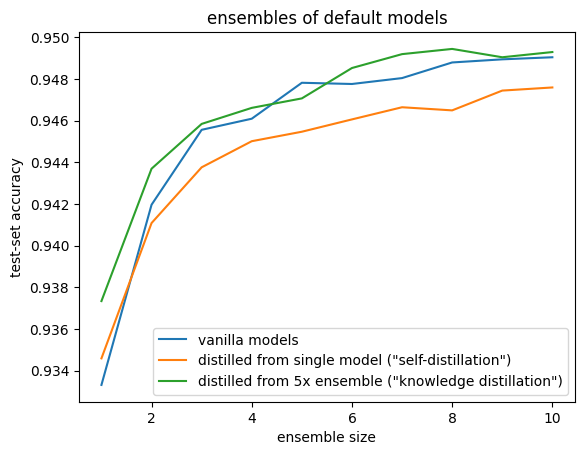

In [107]:
accs = []
kk = range(1, 11)
for k in tqdm(kk): # k is the ensemble size
    # average across 5 choices of the ensemble (this is just to de-noise the result)
    acc = torch.tensor([evaluate(Ensemble(nets0[k*i:k*i+k]), test_loader)
                        for i in range(20//k)]).mean().item()
    accs.append(acc)
plt.plot(kk, accs, label='vanilla models')

accs = []
kk = range(1, 11)
for k in tqdm(kk): # k is the ensemble size
    # average across 5 choices of the ensemble (this is just to de-noise the result)
    acc = torch.tensor([evaluate(Ensemble(nets1[k*i:k*i+k]), test_loader)
                        for i in range(20//k)]).mean().item()
    accs.append(acc)
plt.plot(kk, accs, label='distilled from single model ("self-distillation")')

accs = []
kk = range(1, 11)
for k in tqdm(kk): # k is the ensemble size
    # average across 5 choices of the ensemble (this is just to de-noise the result)
    acc = torch.tensor([evaluate(Ensemble(nets2[k*i:k*i+k]), test_loader)
                        for i in range(20//k)]).mean().item()
    accs.append(acc)
plt.plot(kk, accs, label='distilled from 5x ensemble ("knowledge distillation")')

plt.xlabel('ensemble size')
plt.ylabel('test-set accuracy')
plt.title('ensembles of default models')
plt.legend()
plt.show()